In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [ ]:
import sys

In [ ]:
sys.path.append('../')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
import json

import phononet as pn

In [ ]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

In [ ]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [ ]:
from tensorflow import keras

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


In [ ]:
import numpy as np

In [ ]:
X_train=train.X.numpy()
y_train=np.array(train.y)[...,np.newaxis]

X_val=test.X.numpy()
y_val=np.array(test.y)[...,np.newaxis]

In [ ]:
X_train.shape,y_train.shape

In [ ]:
train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(1000).batch(32)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(32)

In [ ]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, size, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(**kwargs) # handles base args (e.g., dtype)
        self.size=size
        self.total_cm = self.add_weight("total", shape=(size,size), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.size)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    


In [ ]:
class MySequential(keras.Sequential):
    
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    
    def train_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  # Forward pass
                # Compute the loss value.
                # The loss function is configured in `compile()`.
                loss = self.compiled_loss(
                    y,
                    y_pred,
                    regularization_losses=self.losses,
                )

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
        
        
    def test_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            y_pred = self(x, training=False)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
            


In [ ]:
from tensorflow.keras.models import Sequential

In [26]:
model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    keras.layers.BatchNormalization(name='bn0',axis=[3]),
    #
    keras.layers.Conv2D(64,(3,3),padding='same'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn1',axis=[3]), # batch normalization on everything but last dimension
    keras.layers.MaxPool2D((1,2)),
    keras.layers.Dropout(.2),
    #
    keras.layers.Conv2D(128,(3,3),padding='same'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn2',axis=[3]),
    keras.layers.MaxPool2D((1,3)),
    keras.layers.Dropout(.2),
    #
    keras.layers.Conv2D(150,(3,3),padding='same'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn3',axis=[3]),
    keras.layers.MaxPool2D((1,2)),
    keras.layers.Dropout(.2),
    #
    keras.layers.Conv2D(200,(3,3),padding='same'),
    keras.layers.Activation(keras.activations.elu),
    keras.layers.BatchNormalization(name='bn4',axis=[3]),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(.2),
    keras.layers.Dense(30)

])

model.summary()

Model: "my_sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 12, 1500, 1)       0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 12, 1500, 1)       4         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 1500, 64)      640       
_________________________________________________________________
activation_4 (Activation)    (None, 12, 1500, 64)      0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 12, 1500, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 750, 64)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 750, 64)   

In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [ ]:
history=model.fit(train_data,validation_data=val_data,epochs=100)

In [ ]:
#model.save_weights('phase_1_weights_100_epochs')

In [ ]:
import json
#json.dump(history.history,open('phase_1_history_100_epochs.json','w'),indent=2)

In [ ]:
history_dict=json.load(open('phase_1_history_100_epochs.json'))

In [ ]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [ ]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

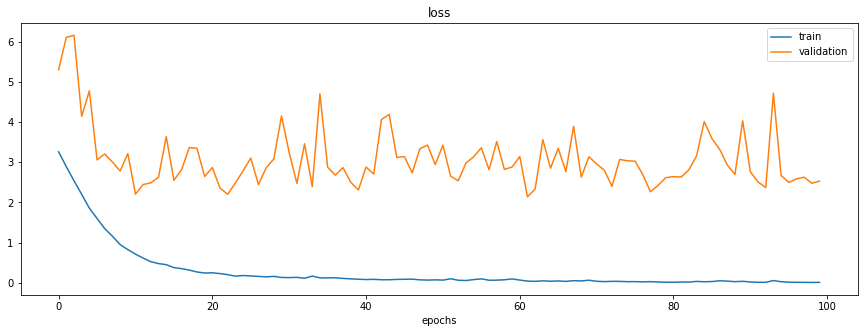

In [27]:
plt.figure(figsize=(15,5))
plt.plot(history_dict['loss'],label='train')
plt.plot(history_dict['val_loss'],label='validation')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()

Text(0.5, 1.0, 'accuracy')

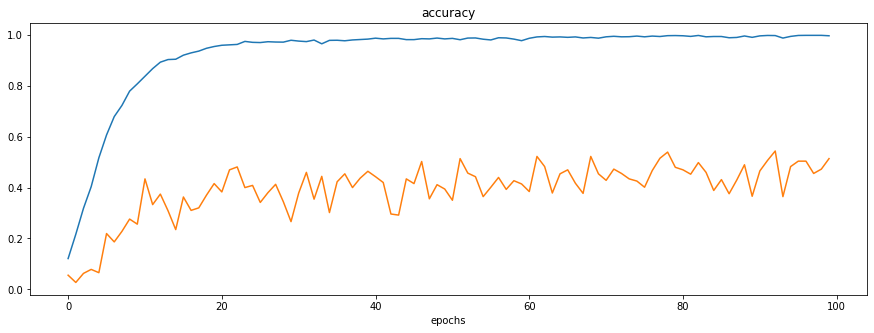

In [28]:
plt.figure(figsize=(15,5))
plt.plot(history_dict['accuracy'],label='train')
plt.plot(history_dict['val_accuracy'],label='validation')
plt.xlabel('epochs')
plt.title('accuracy')

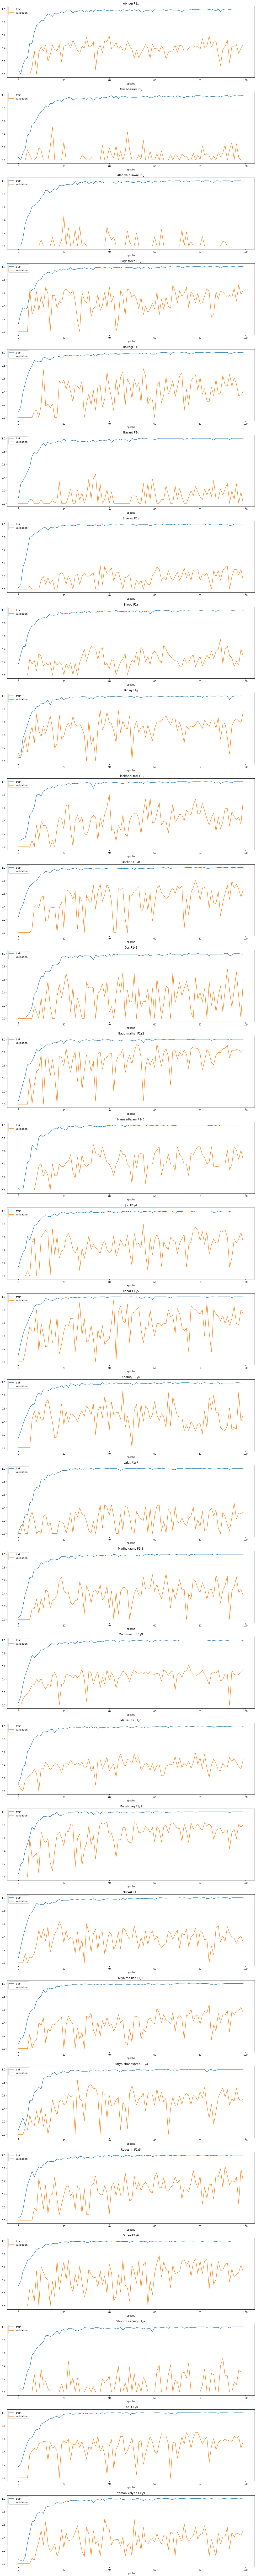

In [32]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict['F1_{}'.format(i)],label='train')
    plt.plot(history_dict['val_F1_{}'.format(i)],label='validation')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
plt.tight_layout()